# Deep Chem Library to predict reaction energies of molecular dataset

## Load the saved and trained model to predict properties 

## Import the necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import deepchem as dc
from rdkit import Chem
from deepchem.splits.splitters import ScaffoldSplitter,SpecifiedSplitter,RandomSplitter
from deepchem.models import GraphConvModel
import pickle
from keras.callbacks import ModelCheckpoint,EarlyStopping
from deepchem.utils.save import load_from_disk
from deepchem.utils.save import save_to_disk
from deepchem.utils.evaluate import Evaluator
import os

deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.


define the model directory

In [2]:
#model_dir = "./models/logD"
model_dir = './tf_ckpt_v2'
logD_model = dc.models.GraphConvModel(n_tasks=1, batch_size=100, mode='regression', dropout=0.25,model_dir= model_dir,random_seed=0)



here is the available checkpoints

In [3]:
logD_model.get_checkpoints()

['./tf_ckpt_v2/ckpt-81', './tf_ckpt_v2/ckpt-82', './tf_ckpt_v2/ckpt-83', './tf_ckpt_v2/ckpt-84', './tf_ckpt_v2/ckpt-85', './tf_ckpt_v2/ckpt-86', './tf_ckpt_v2/ckpt-87', './tf_ckpt_v2/ckpt-88', './tf_ckpt_v2/ckpt-89', './tf_ckpt_v2/ckpt-90', './tf_ckpt_v2/ckpt-91', './tf_ckpt_v2/ckpt-92', './tf_ckpt_v2/ckpt-93', './tf_ckpt_v2/ckpt-94', './tf_ckpt_v2/ckpt-95', './tf_ckpt_v2/ckpt-96', './tf_ckpt_v2/ckpt-97', './tf_ckpt_v2/ckpt-98', './tf_ckpt_v2/ckpt-99', './tf_ckpt_v2/ckpt-100']

call the exact checkpoint we want from trained model

In [4]:
logD_model.restore('./tf_ckpt_v2/ckpt-85/ckpt-178')

Import train data

In [5]:
input_data="../final_data/train.csv"

In [6]:
# Run before every test for reproducibility
def seed_all():
    np.random.seed(123)
    tf.random.set_seed(123)

In [7]:
tasks=['reaction_energy']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="reactant_smiles",featurizer=featurizer)
dataset=loader.featurize(input_data)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


In [8]:
seed_all()
splitter = dc.splits.RandomSplitter() #There is a "split" field in the dataset file where I  defined the training/valid/test set
#splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset,frac_train = 0.8,frac_valid = 0.2, frac_test = 0.0,seed = 0)


Normalize our train and valid data

In [9]:
transformers = dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset, move_mean=True)

In [10]:
train_dataset = transformers.transform(train_dataset)
valid_dataset= transformers.transform(valid_dataset)

In [43]:
metric = dc.metrics.Metric(dc.metrics.r2_score, mode='regression')
# list of evaluation metrics = ["pearson_r2_score", "r2_score", "mean_squared_error","mean_absolute_error", "rms_score", "mae_score", "pearsonr",
#                            "concordance_index" ]
num_epochs = 1
losses_second_train = []
score_second_valid = []
for i in range(num_epochs):
    loss_train = logD_model.fit(train_dataset, nb_epoch=1)
    # checkpoint_interval causes the model not to save a checkpoint.
    #R2_valid = model.evaluate(test_dataset,[metric])['pearsonr']
    R2_valid = logD_model.evaluate(valid_dataset,[metric])['r2_score']
    print("Epoch %d loss_train: %f R2_valid: %f " % (i, loss_train,R2_valid))

    losses_second_train.append(loss_train)
    score_second_valid.append(R2_valid)
   

Epoch 0 loss_train: 0.049441 R2_valid: 0.929343 


In [11]:
train_y = train_dataset.y

In [12]:
train_pred= logD_model.predict(train_dataset)

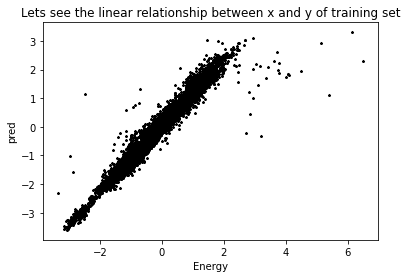

In [13]:
import matplotlib.pyplot as plt
plt.title('Lets see the linear relationship between x and y of training set')
plt.scatter(train_y,train_pred,s=5,c='black',marker='*')
plt.xlabel('Energy')
plt.ylabel('pred')
plt.show()

Evaluate the model

In [14]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
train_mae = logD_model.evaluate(train_dataset, [metric],[transformers])


print("mae",train_mae)

mae {'mean_absolute_error': 0.007382967269007532}


In [15]:
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
train_mse = logD_model.evaluate(train_dataset, [metric],[transformers])
from math import sqrt
print("rmse",sqrt(list(train_mse.values())[0]))

rmse 0.010603025766951725


In [16]:
metric = dc.metrics.Metric(dc.metrics.r2_score)
train_r2 = logD_model.evaluate(train_dataset, [metric],[transformers])
print("r2",train_r2)

r2 {'r2_score': 0.92838832887301}


Compare the results with the sklearn evaluation resuts

In [17]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
print("MSE" , mean_squared_error(train_y,train_pred))
print("RMSE" , sqrt(mean_squared_error(train_y,train_pred)))
print("MAE", mean_absolute_error(train_y,train_pred))
print("R2", r2_score(train_y,train_pred))

MSE 0.07161167112699009
RMSE 0.2676035708412541
MAE 0.18633439623890646
R2 0.92838832887301


Import the test data

In [18]:
df_test= pd.read_csv('../final_data/test1.csv')

In [19]:
input_data_test= '../final_data/test1.csv'
tasks=['reaction_energy']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="reactant_smiles",featurizer=featurizer)
dataset=loader.featurize(input_data_test)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


In [20]:
# Normalize them
transformers1 = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset, move_mean=True)

In [21]:
dataset = transformers1.transform(dataset)

In [22]:
test_pred= logD_model.predict(dataset)

In [23]:
test_y = dataset.y

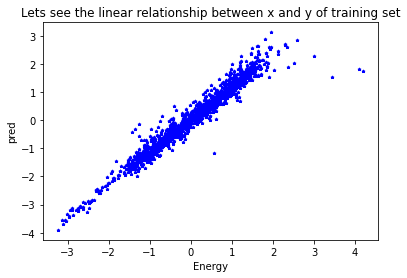

In [24]:
import matplotlib.pyplot as plt
plt.title('Lets see the linear relationship between x and y of training set')
plt.scatter(test_y,test_pred,s=8,c='blue',marker='*')
plt.xlabel('Energy')
plt.ylabel('pred')
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from math import sqrt

In [26]:
print("MSE:",mean_squared_error(test_y,test_pred))
print("RMSE",sqrt(mean_squared_error(test_y,test_pred)))
print("MAE",mean_absolute_error(test_y,test_pred))
print("R2",r2_score(test_y,test_pred))

MSE: 0.07882988040199017
RMSE 0.2807665941703004
MAE 0.1977119906699428
R2 0.9211701195980099


In [27]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
test1_mae = logD_model.evaluate(dataset, [metric],[transformers1])


print("mae",test1_mae)

mae {'mean_absolute_error': 0.00787349931810819}


In [28]:
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
test1_mse = logD_model.evaluate(dataset, [metric],[transformers1])
print("rmse",sqrt(list(test1_mse.values())[0]))

rmse 0.011180988974198258


In [29]:
metric = dc.metrics.Metric(dc.metrics.r2_score)
test1_r2 = logD_model.evaluate(dataset, [metric],[transformers1])
print("r2",test1_r2)

r2 {'r2_score': 0.9211701195980099}


Import the test2 data

In [30]:
input_data_test2= '../final_data/test2.csv'
tasks=['reaction_energy']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="reactant_smiles",featurizer=featurizer)
dataset2=loader.featurize(input_data_test2)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


In [31]:
test2_y = dataset2.y

(array([ 11.,  29.,  97., 169., 107., 137., 257., 278., 354.,  41.]),
 array([-0.10653, -0.093107, -0.079684, -0.066261, -0.052838,
        -0.039415000000000006, -0.025992, -0.01256900000000001,
        0.0008539999999999937, 0.014276999999999998, 0.0277], dtype=object),
 <BarContainer object of 10 artists>)

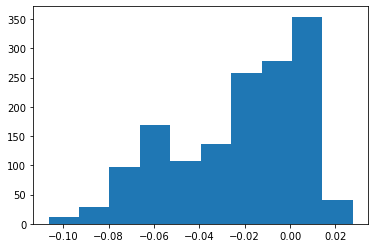

In [32]:
plt.hist(test2_y)

In [33]:
test_pred2= logD_model.predict(dataset2)

(array([  6.,  12.,  37., 207., 180.,  99., 137., 252., 296., 254.]),
 array([-2.3410168 , -1.9874713 , -1.6339258 , -1.2803802 , -0.9268348 ,
        -0.57328933, -0.21974385,  0.13380164,  0.48734713,  0.8408926 ,
         1.1944381 ], dtype=float32),
 <BarContainer object of 10 artists>)

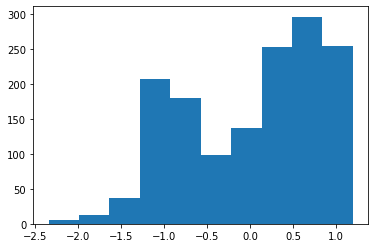

In [34]:
plt.hist(test_pred2)

In [35]:
## normilze them
transformers2 = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset2,move_mean=True)

In [36]:
dataset2 = transformers2.transform(dataset2)

In [37]:
test_pred2= logD_model.predict(dataset2)

In [38]:
test2_y = dataset2.y

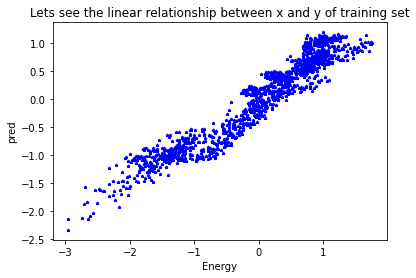

In [39]:
plt.title('Lets see the linear relationship between x and y of training set')
plt.scatter(test2_y,test_pred2,s=8,c='blue',marker='*')
plt.xlabel('Energy')
plt.ylabel('pred')
plt.show()

In [40]:
print("MSE" , mean_squared_error(test2_y,test_pred2))
print("RMSE" , sqrt(mean_squared_error(test2_y,test_pred2)))
print("MAE", mean_absolute_error(test2_y,test_pred2))
print("R2", r2_score(test2_y,test_pred2))

MSE 0.10271904413601148
RMSE 0.3204981187714079
MAE 0.25073482778884315
R2 0.8972809558639886


In [41]:
dataset2

<DiskDataset X.shape: (1480,), y.shape: (1480, 1), w.shape: (1480, 1), task_names: ['reaction_energy']>

(array([  6.,  12.,  37., 207., 180.,  99., 137., 252., 296., 254.]),
 array([-2.3410168 , -1.9874713 , -1.6339258 , -1.2803802 , -0.9268348 ,
        -0.57328933, -0.21974385,  0.13380164,  0.48734713,  0.8408926 ,
         1.1944381 ], dtype=float32),
 <BarContainer object of 10 artists>)

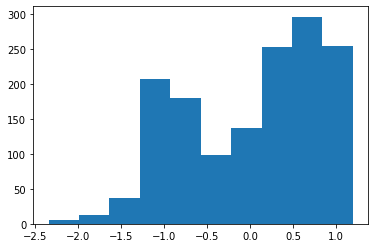

In [42]:
plt.hist(test_pred2) 

(array([ 11.,  29.,  97., 169., 107., 137., 257., 278., 354.,  41.]),
 array([-2.96115703, -2.48928285, -2.01740866, -1.54553448, -1.0736603 ,
        -0.60178611, -0.12991193,  0.34196225,  0.81383643,  1.28571062,
         1.7575848 ]),
 <BarContainer object of 10 artists>)

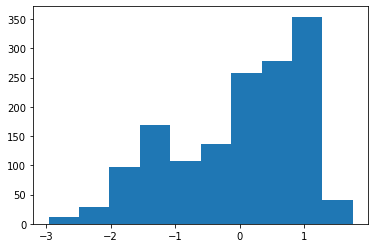

In [43]:
plt.hist(test2_y)

In [44]:
print("MSE",mean_squared_error(test2_y,test_pred2))
print("RMSE",sqrt(mean_squared_error(test2_y,test_pred2)))
print("MAE",mean_absolute_error(test2_y,test_pred2))
print("R2",r2_score(test2_y,test_pred2))

MSE 0.10271904413601148
RMSE 0.3204981187714079
MAE 0.25073482778884315
R2 0.8972809558639886


In [45]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
test2_mae = logD_model.evaluate(dataset2, [metric],[transformers2])


print("mae",test2_mae)

mae {'mean_absolute_error': 0.007132438504035394}


In [46]:
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
test2_mse = logD_model.evaluate(dataset2, [metric],[transformers2])
print("rmse",sqrt(list(test2_mse.values())[0]))

rmse 0.009116934982487562


In [47]:
metric = dc.metrics.Metric(dc.metrics.r2_score)
test2_r2 = logD_model.evaluate(dataset2, [metric],[transformers2])
print("mse",test2_r2)

mse {'r2_score': 0.8972809558639885}


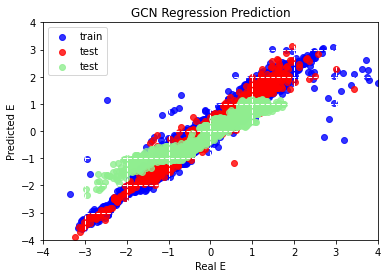

In [48]:
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.title("GCN Regression Prediction")
plt.xlabel("Real E")
plt.ylabel("Predicted E")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(train_y,train_pred, 
            color="blue", alpha=0.8, label="train")
plt.scatter(test_y,test_pred, 
            color="red", alpha=0.8, label="test")
plt.scatter(test2_y,test_pred2, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()